In [1]:
import hes1_langevin_Antoine as langevin
import hes1_master_Antoine as master
import hes1_utils_Antoine as utils
import hes1_utils_general as general
import jochen_utils as jutils

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import scipy.interpolate as spinter
import scipy.fft
import time
import datetime as dt
import os
from scipy.stats import norm
from scipy.stats import chi2
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import wasserstein_distance
from numba import jit
from scipy.special import rel_entr


import warnings
warnings.filterwarnings("ignore")

In [2]:
ratio=(1+np.sqrt(5))/2

In [12]:
date_and_time=time.localtime()
string_date=str(date_and_time.tm_year)+'-'+str(date_and_time.tm_mon)+'-'+str(date_and_time.tm_mday)+'-'+str(date_and_time.tm_hour)+'-'+str(date_and_time.tm_min)+'-'+str(date_and_time.tm_sec)

In [13]:
os.makedirs(os.getcwd() + '\\paper plots ' + string_date)

read_directory = os.getcwd() + '\\paper plots ' + string_date        #specify here the folder you want to use

try:
    os.makedirs(read_directory+'\\data1')
    os.makedirs(read_directory+'\\data2')
    os.makedirs(read_directory+'\\plots')
except FileExistsError:
    pass


In [3]:
font = {
    'family' : 'Arial',
    'color'  : 'black',
    'weight' : 'normal',
    'size'   : 36,
}

legendFont = 20

# Influence of the swtiching noise on the full model (time series)

We plot timeseries of the full model (standard Gillespie algorithm) and of the full model using average switching noise (Gillespie algorithm where the environment switching is replaced by the Hill function).
Functions are defined in the file "master".

## 1) First set of parameters (_PARAM1_)

First we use the following set of parameter values, referred to as _PARAM1_:

In [ ]:
alpha_m=1
alpha_p=1
mu_m=0.03
mu_p=0.03
h=4.1
P_0=10

T=10000
delta_t=0.001

n_t=int(T/delta_t)

val_lambda=0.1
val_Omega=10000
val_tau=19.7

In [ ]:
t0=time.time()

time_trajm,mRNA_trajm,Hes1_trajm = master.one_trajectory(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,mu_p=mu_p,h=h,P_0=P_0,
                                                      lambda_s=val_lambda,        
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T,
                                                      Omega=val_Omega)

time.time()-t0

In [ ]:
time_trajmns,mRNA_trajmns,Hes1_trajmns = master.one_trajectory_noSwitchNoise(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,
                                                      mu_p=mu_p,
                                                      h=h,
                                                      P_0=P_0,
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T,
                                                      Omega=val_Omega) 

In [ ]:
t_ref = np.linspace(0,T,T)
mRNA_trajm_toPlot=spinter.interp1d(time_trajm,mRNA_trajm,kind="zero")(t_ref)
Hes1_trajm_toPlot=spinter.interp1d(time_trajm,Hes1_trajm,kind="zero")(t_ref)
mRNA_trajmns_toPlot=spinter.interp1d(time_trajmns,mRNA_trajmns,kind="zero")(t_ref)
Hes1_trajmns_toPlot=spinter.interp1d(time_trajmns,Hes1_trajmns,kind="zero")(t_ref)

In [ ]:
fig,ax=plt.subplots(2,1, figsize=(5*ratio,5))
    
ax[0].set_title('Hes1 concentration over time',fontdict=font) 
ax[0].set_xlabel('time',fontdict=font) 
ax[0].set_ylabel('Hes1 concentration',fontdict=font) 

#ax[0].set_ylim(10,150)
#ax[0].set_xlim(5000,10000)
    
linem, = ax[0].plot(time_trajm,Hes1_trajm, color = 'blue')
    
ax[0].legend([linem], ['Full model'],loc='upper right')


ax[1].set_xlabel('time',fontdict=font) 
ax[1].set_ylabel('Hes1 concentration',fontdict=font)

#ax[1].set_ylim(10,150)
#ax[1].set_xlim(5000,10000)

linemns, = ax[1].plot(time_trajmns,Hes1_trajmns, color = 'orange')

ax[1].legend([linemns], ['Full model with average switching rate'], loc='upper right')

plt.savefig(read_directory+'\\plots\\trajP - comparison full with vs without switching - param1.pdf')
    
plt.show()

In [ ]:
fig,ax=plt.subplots(2,1, figsize=(5*ratio,5))
    
ax[0].set_title('mRNA concentration over time',fontdict=font) 
ax[0].set_xlabel('time',fontdict=font) 
ax[0].set_ylabel('mRNA concentration',fontdict=font) 

ax[0].set_ylim(0,5)
ax[0].set_xlim(5000,10000)
    
linem, = ax[0].plot(t_ref,mRNA_trajm_toPlot, color = 'blue')
    
ax[0].legend([linem], ['Full model'],loc='upper right')


ax[1].set_xlabel('time',fontdict=font) 
ax[1].set_ylabel('mRNA concentration',fontdict=font)

ax[1].set_ylim(0,5)
ax[1].set_xlim(5000,10000)

linemns, = ax[1].plot(t_ref,mRNA_trajmns_toPlot, color = 'orange')

ax[1].legend([linemns], ['Full model with average switching rate'], loc='upper right')
    
plt.show()

## 2) Second set of parameters (_PARAM2_)

Next we use the set of values proposed in _Quantitative single-cell live imaging links HES5 dynamics with cell-state and fate in murine neurogenesis_ (Cerys S. Manning, Veronica Biga, James Boyd, Jochen Kursawe, Bodvar Ymisson, David G. Spiller, Christopher M. Sanderson, Tobias Galla, Magnus Rattray, Nancy Papalopulu), figure 6. These values are referred to as _PARAM2_.

In [9]:
'''alpha_m=0.64
alpha_p=17.32
mu_m=np.log(2)/30
mu_p=np.log(2)/90
h=5.59
P_0=88288.6

T=10000
delta_t=0.01

n_t=int(T/delta_t)

val_lambda=0.1
val_Omega=100
val_tau=34'''

alpha_m=39.93
alpha_p=21.56
mu_m=np.log(2)/30
mu_p=np.log(2)/90
h=4.78
P_0=24201.01

T=10000
delta_t=0.00005

n_t=int(T/delta_t)

val_lambda=10
val_Omega=100
val_tau=33

In [5]:
time_trajm,mRNA_trajm,Hes1_trajm = master.one_trajectory(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,mu_p=mu_p,h=h,P_0=P_0,
                                                      lambda_s=val_lambda,        
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T,
                                                      Omega=val_Omega)

time_trajmns,mRNA_trajmns,Hes1_trajmns = master.one_trajectory_noSwitchNoise(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,
                                                      mu_p=mu_p,
                                                      h=h,
                                                      P_0=P_0,
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T,
                                                      Omega=val_Omega)

time_trajmdet,mRNA_trajmdet,Hes1_trajmdet = langevin.resolve_ODE(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,mu_p=mu_p,h=h,
                                                      P_0=P_0,
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T,
                                                      delta_t=0.01)


In [10]:
time_trajmnd,mRNA_trajmnd,Hes1_trajmnd = langevin.one_trajectory_PDMP(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,mu_p=mu_p,h=h,
                                                      P_0=P_0,
                                                      lambda_s=val_lambda,        
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T, delta_t=delta_t)

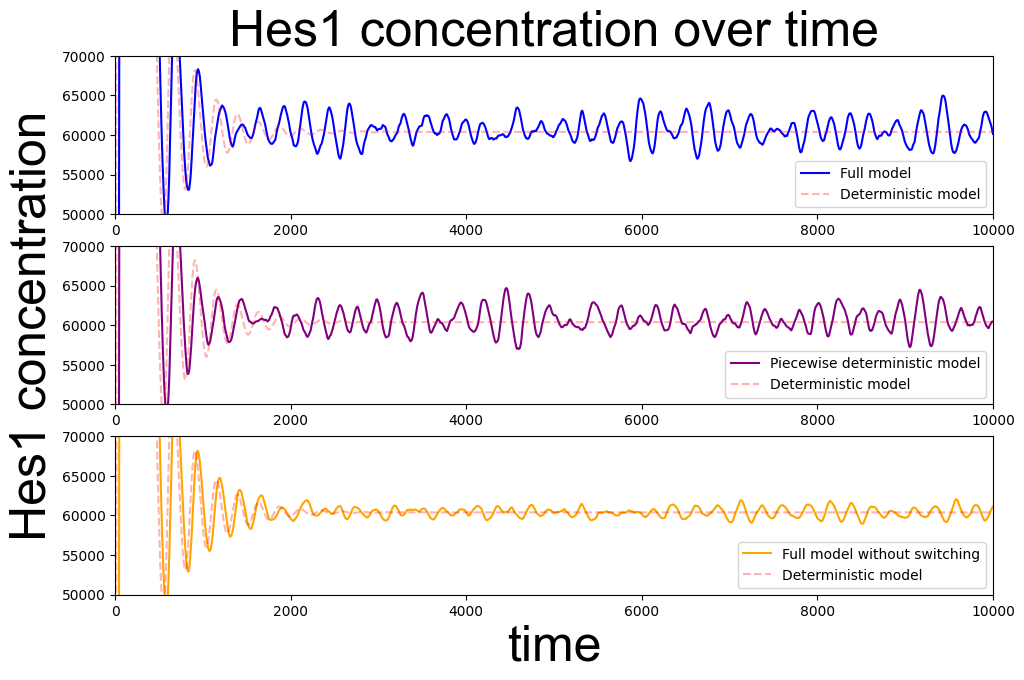

In [14]:
fig,ax=plt.subplots(3,1, figsize=(7*ratio,7))
    
ax[0].set_title('Hes1 concentration over time',fontdict=font) 

ax[0].set_ylim(50000,70000)
ax[0].set_xlim(0,10000)
    
linem, = ax[0].plot(time_trajm,Hes1_trajm, color = 'blue')
linedet, = ax[0].plot(time_trajmdet,Hes1_trajmdet,'--', color = 'red', alpha=0.3)
ax[0].legend([linem,linedet], ['Full model','Deterministic model'],loc='lower right')



ax[1].set_ylabel('Hes1 concentration',fontdict=font)
ax[1].set_ylim(50000,70000)
ax[1].set_xlim(0,10000)

linemnd, = ax[1].plot(time_trajmnd,Hes1_trajmnd, color = 'purple')
linedet, = ax[1].plot(time_trajmdet,Hes1_trajmdet,'--', color = 'red', alpha=0.3)
ax[1].legend([linemnd,linedet], ['Piecewise deterministic model','Deterministic model'], loc='lower right')



ax[2].set_xlabel('time',fontdict=font)
ax[2].set_ylim(50000,70000)
ax[2].set_xlim(0,10000)

linemns, = ax[2].plot(time_trajmns,Hes1_trajmns, color = 'orange')
linedet, = ax[2].plot(time_trajmdet,Hes1_trajmdet,'--', color = 'red', alpha=0.3)
ax[2].legend([linemns,linedet], ['Full model without switching','Deterministic model'], loc='lower right')


plt.savefig(read_directory+'\\plots\\trajP - comparison full with vs without switching - param2 - ter.pdf')
    
plt.show()

In [ ]:
fig,ax=plt.subplots(2,1, figsize=(5*ratio,5))
    
ax[0].set_title('mRNA concentration over time',fontdict=font) 
ax[0].set_xlabel('time',fontdict=font) 
ax[0].set_ylabel('mRNA concentration',fontdict=font) 

ax[0].set_ylim(0,200)
ax[0].set_xlim(5000,10000)
    
linem, = ax[0].plot(t_ref,mRNA_trajm_toPlot, color = 'blue')
    
ax[0].legend([linem], ['Full model'],loc='upper right')


ax[1].set_xlabel('time',fontdict=font) 
ax[1].set_ylabel('mRNA concentration',fontdict=font)

ax[1].set_ylim(0,200)
ax[1].set_xlim(5000,10000)

linemns, = ax[1].plot(t_ref,mRNA_trajmns_toPlot, color = 'orange')

ax[1].legend([linemns], ['Full model with average switching rate'], loc='upper right')
    
plt.show()

# Comparison Langevin VS full model

We plot timeseries of the full model (standard Gillespie algorithm) and of the Langevin model i.e using SPDEs.
Functions are defined in the files "hes1_langevin_Antoine.py" and "hes1_master_Antoine.py".

## Time series for _PARAM1_

In [ ]:
alpha_m=1
alpha_p=1
mu_m=0.03
mu_p=0.03
h=4.1
P_0=10

T=10000
delta_t=0.001

n_t=int(T/delta_t)

val_lambda=1
val_Omega=500
val_tau=18.7

In [ ]:
m_stat,p_stat = utils.resolve_stationary_state(alpha_m,mu_m,alpha_p,mu_p,h,P_0)

In [ ]:
time_trajm,mRNA_trajm,Hes1_trajm = master.one_trajectory(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,
                                                      mu_p=mu_p,
                                                      h=h,
                                                      P_0=P_0,
                                                      lambda_s=val_lambda,
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T,
                                                      Omega=val_Omega)
        
time_trajl,mRNA_trajl,Hes1_trajl = langevin.one_trajectory(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,
                                                      mu_p=mu_p,
                                                      h=h,
                                                      P_0=P_0,
                                                      lambda_s=val_lambda,
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T,
                                                      delta_t=delta_t,
                                                      Omega=val_Omega)

time_trajlna,mRNA_trajlna,Hes1_trajlna = langevin.one_trajectory_LNA(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,
                                                      mu_p=mu_p,
                                                      h=h,
                                                      P_0=P_0,
                                                      lambda_s=val_lambda,
                                                      tau=val_tau,
                                                      T=T,
                                                      delta_t=delta_t,
                                                      Omega=val_Omega)

In [ ]:
t_ref = np.linspace(0,T,T)
mRNA_trajm_toPlot=spinter.interp1d(time_trajm,mRNA_trajm,kind="zero")(t_ref)
Hes1_trajm_toPlot=spinter.interp1d(time_trajm,Hes1_trajm,kind="zero")(t_ref)

In [ ]:
fig,ax=plt.subplots(3,1,figsize=(5*ratio,5))
    
ax[0].set_title('Hes1 concentration over time',fontdict=font) 
ax[0].set_ylabel('Hes1 concentration',fontdict=font) 

ax[0].set_ylim(5,60)
ax[0].set_xlim(5000,10000)
    
linem,=ax[0].plot(time_trajm,Hes1_trajm, color = 'blue')
ax[0].legend([linem], ['Full model'], loc='upper right')



ax[1].set_ylabel('Hes1 concentration',fontdict=font)

ax[1].set_ylim(5,60)
ax[1].set_xlim(5000,10000)
    
linel,=ax[1].plot(time_trajl,Hes1_trajl, color = 'green')
ax[1].legend([linel], ['Langevin model'], loc='upper right')



ax[2].set_xlabel('time',fontdict=font) 
ax[2].set_ylabel('Hes1 concentration',fontdict=font)

ax[2].set_ylim(5,60)
ax[2].set_xlim(5000,10000)
    
linelna,=ax[2].plot(time_trajlna,Hes1_trajlna, color = 'red')
ax[2].legend([linelna], ['LNA model'], loc='upper right')



#plt.savefig(read_directory+'\\plots\\trajP - comparison Full vs Langevin - param1.pdf')
plt.show()

In [ ]:
fig,ax=plt.subplots(3,1,figsize=(5*ratio,5))
    
ax[0].set_title('Hes1 concentration over time',fontdict=font) 
ax[0].set_ylabel('Hes1 concentration',fontdict=font) 

ax[0].set_ylim(0,1)
ax[0].set_xlim(5000,10000)
    
linem,=ax[0].plot(t_ref,mRNA_trajm_toPlot, color = 'blue')
ax[0].legend([linem], ['Full model'], loc='upper right')



ax[1].set_ylabel('Hes1 concentration',fontdict=font)

ax[1].set_ylim(0,1)
ax[1].set_xlim(5000,10000)
    
linel,=ax[1].plot(time_trajl,mRNA_trajl, color = 'green')
ax[1].legend([linel], ['Langevin model'], loc='upper right')



ax[2].set_xlabel('time',fontdict=font) 
ax[2].set_ylabel('Hes1 concentration',fontdict=font)

ax[2].set_ylim(0,1)
ax[2].set_xlim(5000,10000)
    
linelna,=ax[2].plot(time_trajlna,mRNA_trajlna, color = 'red')
ax[2].legend([linelna], ['LNA model'], loc='upper right')


## Time series for _PARAM2_

In [15]:
'''alpha_m=0.64
alpha_p=17.32
mu_m=np.log(2)/30
mu_p=np.log(2)/90
h=5.59
P_0=88288.6

T=10000
delta_t=0.01

n_t=int(T/delta_t)

val_lambda=100
val_Omega=1
val_tau=34'''

alpha_m=39.93
alpha_p=21.56
mu_m=np.log(2)/30
mu_p=np.log(2)/90
h=4.78
P_0=24201.01

T=10000
delta_t=0.01

n_t=int(T/delta_t)

val_lambda=10
val_Omega=100
val_tau=33

In [16]:
m_stat,p_stat = utils.resolve_stationary_state(alpha_m,mu_m,alpha_p,mu_p,h,P_0)

In [17]:
time_trajm,mRNA_trajm,Hes1_trajm = master.one_trajectory(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,
                                                      mu_p=mu_p,
                                                      h=h,
                                                      P_0=P_0,
                                                      lambda_s=val_lambda,
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T,
                                                      Omega=val_Omega)
        
time_trajl,mRNA_trajl,Hes1_trajl = langevin.one_trajectory(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,
                                                      mu_p=mu_p,
                                                      h=h,
                                                      P_0=P_0,
                                                      lambda_s=val_lambda,
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T,
                                                      delta_t=delta_t,
                                                      Omega=val_Omega)

time_trajlna,mRNA_trajlna,Hes1_trajlna = langevin.one_trajectory_LNA(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,
                                                      mu_p=mu_p,
                                                      h=h,
                                                      P_0=P_0,
                                                      lambda_s=val_lambda,
                                                      tau=val_tau,
                                                      T=T,
                                                      delta_t=delta_t,
                                                      Omega=val_Omega)

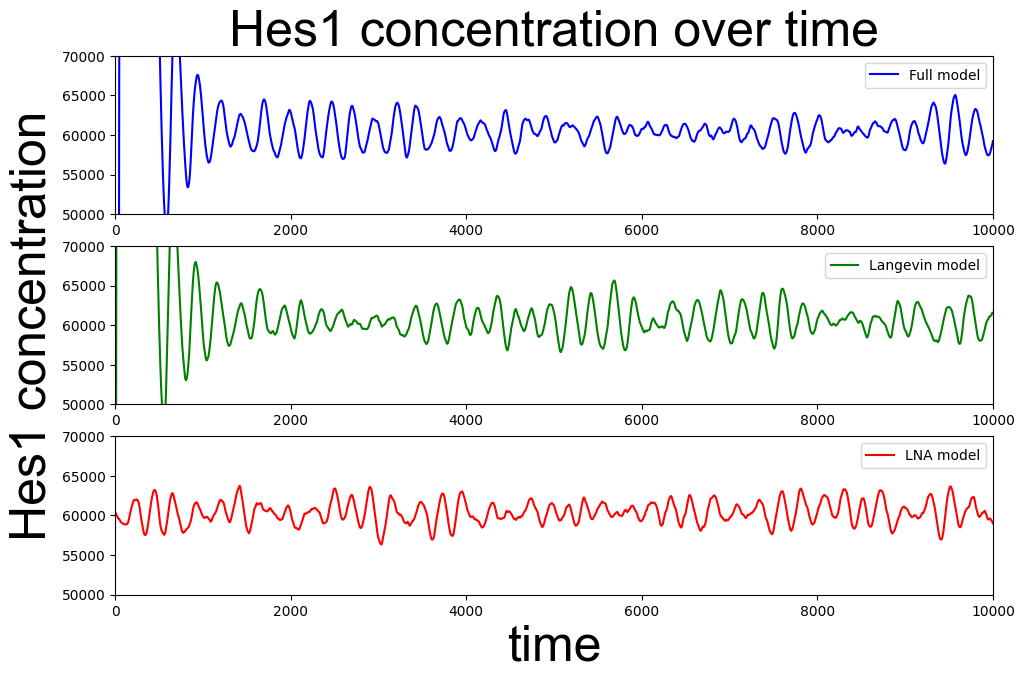

In [19]:
fig,ax=plt.subplots(3,1,figsize=(7*ratio,7))
    
ax[0].set_title('Hes1 concentration over time', fontdict= font) 

ax[0].set_ylim(50000,70000)
ax[0].set_xlim(0,10000)
    
linem,=ax[0].plot(time_trajm,Hes1_trajm, color = 'blue')
ax[0].legend([linem], ['Full model'], loc='upper right')


ax[1].set_ylabel('Hes1 concentration', fontdict= font) 

ax[1].set_ylim(50000,70000)
ax[1].set_xlim(0,10000)
    
linel,=ax[1].plot(time_trajl,Hes1_trajl, color = 'green')
ax[1].legend([linel], ['Langevin model'], loc='upper right')



ax[2].set_xlabel('time', fontdict= font) 

ax[2].set_ylim(50000,70000)
ax[2].set_xlim(0,10000)
    
linelna,=ax[2].plot(time_trajlna,Hes1_trajlna, color = 'red')
ax[2].legend([linelna], ['LNA model'], loc='upper right')

plt.savefig(read_directory+'\\plots\\trajP - comparison Full vs Langevin - param2.pdf')
plt.show()

In [ ]:
time_trajdet,mRNA_trajdet,Hes1_trajdet = langevin.resolve_ODE(alpha_m=alpha_m,alpha_p=alpha_p,mu_m=mu_m,
                                                      mu_p=mu_p,
                                                      h=h,
                                                      P_0=P_0,
                                                      tau=val_tau,
                                                      P_init=0,
                                                      M_init=0,
                                                      T=T,
                                                      delta_t=delta_t)

fig,ax=plt.subplots(1,1,figsize=(4*ratio,4))
    
ax.set_title('Hes1 concentration over time', fontdict= font) 
ax.set_ylabel('Hes1 concentration', fontdict= font) 

ax.set_ylim(45000,80000)
ax.set_xlim(0,10000)
    
linem,=ax.plot(time_trajdet,Hes1_trajdet, color = 'black')
ax.legend([linem], ['Deterministic model'], loc='upper right')

Importantly, we observe that the deterministic solution is non oscillating. This is coherent with the results of _Wu, X. P., Eshete, M. (2011). Bifurcation analysis for a model of gene expression with delays.
Communications in Nonlinear Science and Numerical Simulation, 16(2), 1073–1088_:
if $M^*$ and $P^*$ are the constant stationary solution, then define
$$\omega_0^2 = \alpha_m \alpha_p |f'(P^*)| - \mu_m \mu_p,$$
and
$$a = \frac{-\omega_0^2 + \mu_m \mu_p}{\alpha_m \alpha_p f'(P^*)},$$
with $$ \frac{h}{P_0}\frac{(\frac{P^*}{P_0})^{h-1}}{(1+(\frac{P^*}{P_0})^h)^2}.$$

In [ ]:
m_stat,p_stat = utils.resolve_stationary_state(alpha_m,mu_m,alpha_p,mu_p,h,P_0)
w_0=np.sqrt(abs(alpha_m *alpha_p*abs(h/P_0*(p_stat/P_0)**(h-1)/(1+(p_stat/P_0)**h)**2) - mu_m*mu_p))
aaa = (-w_0**2 + mu_m*mu_p)/(alpha_m *alpha_p*(-h/P_0*(p_stat/P_0)**(h-1)/(1+(p_stat/P_0)**h)**2))

Then, denote the increasing sequence $\tau_j$,
$$\tau_j = \frac{1}{\omega_0}(arccos(a)+2\pi j),$$
so that if $\tau_j \leq \tau \leq \tau_{j+1}$, there are at least $j$ oscillating (unbounded) solutions to the problem.

In [ ]:
tau_0 = np.arccos(aaa)/w_0
tau_1 = (np.arccos(aaa) + 2*np.pi)/w_0

tau_0,tau_1

Therefore, we do have $\tau = 33 min < \tau_0 \approx 37.2 min$. Hence, we expect no (unbounded) oscillation in the deterministic model in steady state.